In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from hdbscan import HDBSCAN
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json
import random

/home/user/Git/ecommerce-segments/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.insert(0, '../src/torch_helpers')

from autoencoder import AutoEncoder, AETrainer
from encoding_classifier import EncodingClassifier, ClfTrainer
from lrp import LinearLRP

In [3]:
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Reading Data

In [4]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [5]:
read_query = make_read_query()

In [6]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,fav_category,fav_cat_purchases,fav_cat_avg_item_value,fav_cat_freq_strength,fav_cat_spending_strength,order_items,loyalty_segment,order_value_segment,category_choice_segment,lifetime_status
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,Jeans,1.0,74.99,0.00,0.000000,"{""(70373,\""WranglerÂ® Booty Up Stretch Jean fo...",One-Off Purchasers,None,None,None
1,9418,69,F,United Kingdom,Cardiff,Search,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,Outerwear & Coats,1.0,399.00,0.50,0.900677,"{""(90353,\""Colleen Skirt Slip\"",Women,Intimate...",New Repeat Customer (High Days-to-Order),Ordering High Value Items,None,None
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,Blazers & Jackets,1.0,169.98,0.25,0.696811,"{""(27173,\""Modadorn New Arrivals Spring & fall...",One-Off Purchasers,None,None,None
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,Fashion Hoodies & Sweatshirts,1.0,51.96,0.50,0.722168,"{""(49470,\""Billabong Men's Semi-Button Up Stri...",New Repeat Customer (Mid Days-to-Order),Ordering Low Value,None,None
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,None,NaN,NaN,NaN,NaN,None,Never Ordered,None,None,None


In [7]:
order_items_enriched = read_query("SELECT * FROM order_items_enriched")
order_items_enriched.head()

SELECT * FROM order_items_enriched 



,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,...,product_category,product_department,product_brand,product_name,distribution_center,user_age,user_gender,user_county,user_city,user_traffic_source
0,1,1,1,2953,3,Shipped,2022-07-20 10:32:05,2022-07-20 16:42:00,NaT,NaT,...,Active,Women,Tommy Hilfiger,Tommy Hilfiger Women's 3 Pack Sports Crew,Memphis TN,62,F,South Korea,Bucheon City,Search
1,2,1,1,4731,7,Shipped,2022-07-20 11:05:38,2022-07-20 16:42:00,NaT,NaT,...,Jeans,Women,Joe's Jeans,Joe's Jeans Women's Skinny Jeans,Port Authority of New York/New Jersey NY/NJ,62,F,South Korea,Bucheon City,Search
2,3,1,1,7656,9,Shipped,2022-07-19 11:29:28,2022-07-20 16:42:00,NaT,NaT,...,Blazers & Jackets,Women,eVogues Apparel,Plus size Button Closure Cropped Bolero Jacket...,New Orleans LA,62,F,South Korea,Bucheon City,Search
3,4,2,2,25774,11,Complete,2022-02-20 10:28:57,2022-02-22 12:23:00,2022-02-23 18:29:00,NaT,...,Underwear,Men,Tommy Bahama,Tommy Bahama Tropical Print Boxer Short,Los Angeles CA,65,M,Brasil,Franca,Organic
4,5,3,3,22308,13,Processing,2023-04-23 09:04:57,NaT,NaT,NaT,...,Pants,Men,Dockers,Dockers Men's Limited Offer D2 Stretch Khaki Pant,Philadelphia PA,16,M,United States,Hallandale Beach,Organic


In [8]:
order_items_enriched.columns

Index(['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price', 'cost', 'product_category', 'product_department',
       'product_brand', 'product_name', 'distribution_center', 'user_age',
       'user_gender', 'user_county', 'user_city', 'user_traffic_source'],
      dtype='object')

In [9]:
order_items_enriched.product_category.unique()

array(['Active', 'Jeans', 'Blazers & Jackets', 'Underwear', 'Pants',
       'Sleep & Lounge', 'Swim', 'Sweaters', 'Skirts', 'Shorts',
       'Accessories', 'Fashion Hoodies & Sweatshirts',
       'Suits & Sport Coats', 'Tops & Tees', 'Socks', 'Outerwear & Coats',
       'Dresses', 'Jumpsuits & Rompers', 'Maternity', 'Intimates',
       'Pants & Capris', 'Leggings', 'Plus', 'Socks & Hosiery', 'Suits',
       'Clothing Sets'], dtype=object)

In [10]:
order_items_enriched.status.value_counts()

status
Shipped       54440
Complete      45609
Processing    36388
Cancelled     27090
Returned      18232
Name: count, dtype: int64

# Calculating Features

In [11]:
def calc_categorical_leanings(order_items_enriched: pd.DataFrame, user_gender: str) -> pd.DataFrame:
    order_items_filtered = order_items_enriched.loc[order_items_enriched.user_gender==user_gender]\
                                              .loc[~order_items_enriched.status.isin(['Cancelled', 'Returned'])]\
                                 
    X_cats = order_items_filtered.pivot_table(index='user_id', 
                                              columns=['product_category'], 
                                              values='id', 
                                              aggfunc='count', 
                                              fill_value=0)

    X_aggs = order_items_filtered.groupby('user_id')['sale_price'].agg(['count', 'sum'])
    X_aggs['avg_item_price'] = X_aggs['sum'] / X_aggs['count']

    X_cats = X_cats.apply(lambda x: x / x.sum(), axis=1)
    
    return X_cats

In [12]:
X_cats_m = calc_categorical_leanings(order_items_enriched, 'M')
X_cats_f = calc_categorical_leanings(order_items_enriched, 'F')

In [13]:
print('Category Purchases Male', f'Columns: {X_cats_m.columns}', f'Shape: {X_cats_m.shape}', sep='\n')
print('\nCategory Purchases Female', f'Columns: {X_cats_f.columns}', f'Shape: {X_cats_f.shape}', sep='\n')

Category Purchases Male
Columns: Index(['Accessories', 'Active', 'Fashion Hoodies & Sweatshirts', 'Jeans',
       'Outerwear & Coats', 'Pants', 'Shorts', 'Sleep & Lounge', 'Socks',
       'Suits & Sport Coats', 'Sweaters', 'Swim', 'Tops & Tees', 'Underwear'],
      dtype='object', name='product_category')
Shape: (33080, 14)

Category Purchases Female
Columns: Index(['Accessories', 'Active', 'Blazers & Jackets', 'Clothing Sets',
       'Dresses', 'Fashion Hoodies & Sweatshirts', 'Intimates', 'Jeans',
       'Jumpsuits & Rompers', 'Leggings', 'Maternity', 'Outerwear & Coats',
       'Pants & Capris', 'Plus', 'Shorts', 'Skirts', 'Sleep & Lounge',
       'Socks & Hosiery', 'Suits', 'Sweaters', 'Swim', 'Tops & Tees'],
      dtype='object', name='product_category')
Shape: (33174, 22)


In [14]:
X_cats_m.mean()

product_category
Accessories                      0.060907
Active                           0.057645
Fashion Hoodies & Sweatshirts    0.075391
Jeans                            0.084866
Outerwear & Coats                0.060720
Pants                            0.081456
Shorts                           0.070145
Sleep & Lounge                   0.070194
Socks                            0.070363
Suits & Sport Coats              0.056640
Sweaters                         0.076514
Swim                             0.069642
Tops & Tees                      0.082829
Underwear                        0.082688
dtype: float64

In [15]:
X_cats_f.mean()

product_category
Accessories                      0.045282
Active                           0.042507
Blazers & Jackets                0.035350
Clothing Sets                    0.002277
Dresses                          0.059887
Fashion Hoodies & Sweatshirts    0.055005
Intimates                        0.148552
Jeans                            0.054382
Jumpsuits & Rompers              0.009951
Leggings                         0.035321
Maternity                        0.057097
Outerwear & Coats                0.037372
Pants & Capris                   0.038118
Plus                             0.048123
Shorts                           0.050691
Skirts                           0.023849
Sleep & Lounge                   0.052654
Socks & Hosiery                  0.041098
Suits                            0.011200
Sweaters                         0.047819
Swim                             0.055821
Tops & Tees                      0.047644
dtype: float64

<Axes: xlabel='product_category', ylabel='product_category'>

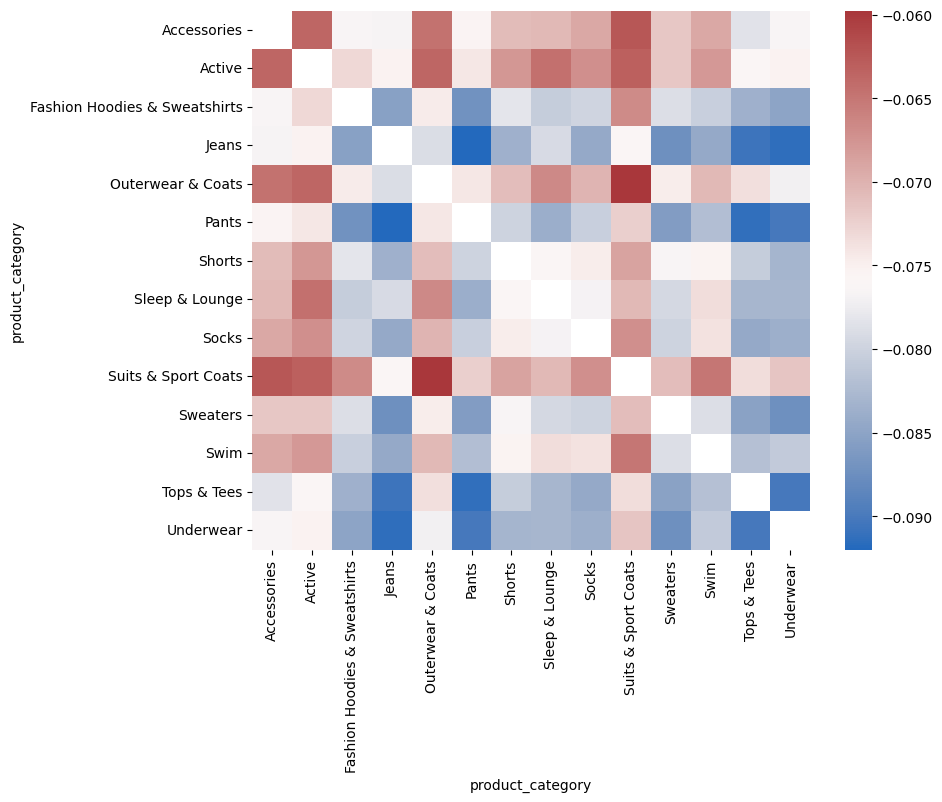

In [16]:
plt.figure(figsize=(9,7))
X_cats_corr = X_cats_m.corr()
m_diag = np.diag(np.diag(np.ones(X_cats_corr.shape, np.bool)))
X_cats_corr.values[m_diag] = None
sns.heatmap(X_cats_corr, cmap='vlag')

<Axes: xlabel='product_category', ylabel='product_category'>

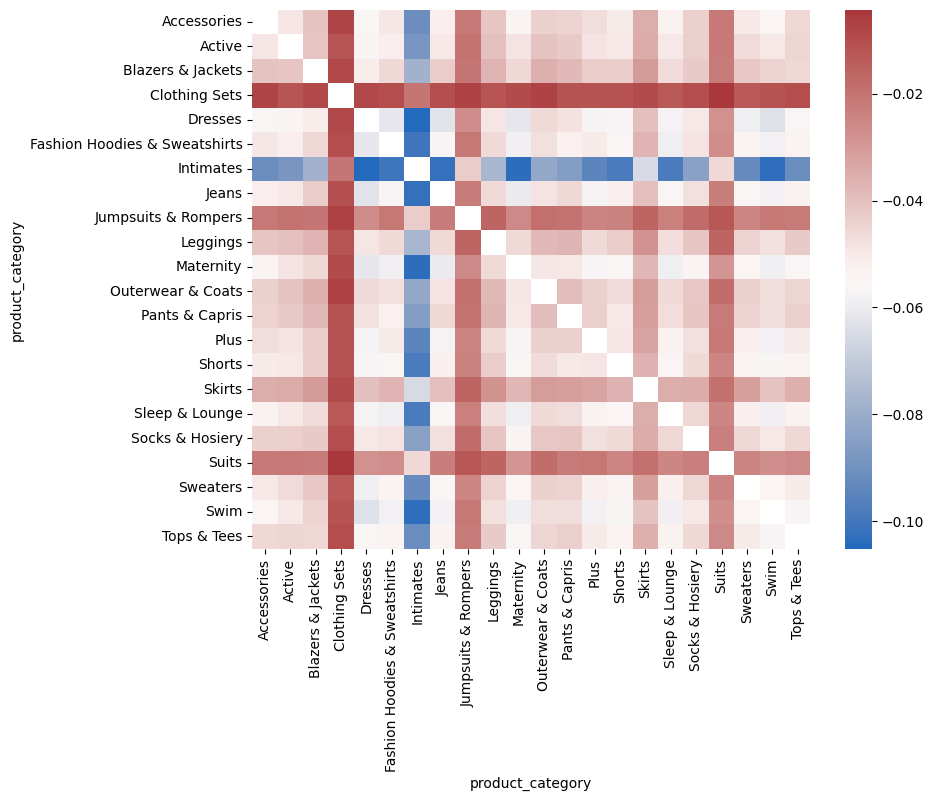

In [17]:
plt.figure(figsize=(9,7))
X_cats_corr = X_cats_f.corr()
m_diag = np.diag(np.diag(np.ones(X_cats_corr.shape, np.bool)))
X_cats_corr.values[m_diag] = None
sns.heatmap(X_cats_corr, cmap='vlag')

# Dimensionality Reduction with Autoencoders

In [18]:
X_cats = X_cats_m

In [19]:
X_cats = X_cats[(X_cats<1).all(axis=1)]

In [20]:
idx = np.arange(X_cats.shape[0])

train_idx, test_idx = train_test_split(idx, test_size=0.1, random_state=RANDOM_STATE)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.1, random_state=RANDOM_STATE)

X_train = X_cats.iloc[train_idx]
X_valid = X_cats.iloc[valid_idx]
X_test = X_cats.iloc[test_idx]

In [21]:
X_train_dfs = [X_train]

for _ in range(10):
    noise = 0.05 * np.random.rand(*X_train.shape) * np.random.randint(-1, 2, size=X_train.shape)
    X_train_noisy = X_train + noise
    X_train_noisy[X_train_noisy<0] = 0
    X_train_noisy[X_train==0] = 0
    X_train_noisy = X_train_noisy.apply(lambda x: x / x.sum(), axis=1)
    X_train_dfs.append(X_train_noisy)
    
X_train_aug = pd.concat(X_train_dfs)

In [22]:
scaler_autoencoder = MinMaxScaler()
X_train_aug_scaled = scaler_autoencoder.fit_transform(X_train_aug)
X_train_scaled = scaler_autoencoder.transform(X_train)
X_valid_scaled = scaler_autoencoder.transform(X_valid)
X_test_scaled = scaler_autoencoder.transform(X_test)
X_pred_scaled = np.concat([X_train_scaled, X_valid_scaled, X_test_scaled])

X_train_aug_scaled = torch.tensor(X_train_aug_scaled, dtype=torch.float32)
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_valid_scaled = torch.tensor(X_valid_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
X_pred_scaled = torch.tensor(X_pred_scaled, dtype=torch.float32)

dataset_train = TensorDataset(X_train_aug_scaled)
train_loader = DataLoader(dataset_train, batch_size=256, shuffle=True)

dataset_valid = TensorDataset(X_valid_scaled)
valid_loader = DataLoader(dataset_valid, batch_size=256, shuffle=True)

In [23]:
ae = AutoEncoder([X_train.shape[1], 12, 6])
ae.encoder, ae.decoder

(Sequential(
   (0): Linear(in_features=14, out_features=12, bias=True)
   (1): ReLU()
   (2): Linear(in_features=12, out_features=6, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=6, out_features=12, bias=True)
   (1): ReLU()
   (2): Linear(in_features=12, out_features=14, bias=True)
 ))

In [24]:
trainer = AETrainer(ae, lr_reduce_patience=5)
trainer.train(train_loader, valid_loader, early_stop_threshold=20)

Using device: cpu
Epoch 1/1000, Validation Loss: 0.018462148
Epoch 2/1000, Validation Loss: 0.014989071
Epoch 3/1000, Validation Loss: 0.013249141
Epoch 4/1000, Validation Loss: 0.011586595
Epoch 5/1000, Validation Loss: 0.011132301
Epoch 6/1000, Validation Loss: 0.010938018
Epoch 7/1000, Validation Loss: 0.010776736
Epoch 8/1000, Validation Loss: 0.010730106
Epoch 9/1000, Validation Loss: 0.010533087
Epoch 10/1000, Validation Loss: 0.010388663
Epoch 11/1000, Validation Loss: 0.010193270
Epoch 12/1000, Validation Loss: 0.010163044
Epoch 13/1000, Validation Loss: 0.010122372
Epoch 14/1000, Validation Loss: 0.010086479
Epoch 15/1000, Validation Loss: 0.010076965
Epoch 16/1000, Validation Loss: 0.010124907
Epoch 17/1000, Validation Loss: 0.010033869
Epoch 18/1000, Validation Loss: 0.010075208
Epoch 19/1000, Validation Loss: 0.010011152
Epoch 20/1000, Validation Loss: 0.010090578
Epoch 21/1000, Validation Loss: 0.009973993
Epoch 22/1000, Validation Loss: 0.010041430
Epoch 23/1000, Validati

np.float64(0.009865209770699343)

In [25]:
mse_loss = torch.nn.MSELoss()

encoded, decoded = ae(X_test_scaled)
test_loss = mse_loss(decoded, X_test_scaled)
test_loss

tensor(0.0094, grad_fn=<MseLossBackward0>)

In [26]:
mse_loss = torch.nn.MSELoss()

encoded, decoded = ae(X_pred_scaled)
pred_loss = mse_loss(decoded, X_pred_scaled)
pred_loss

tensor(0.0094, grad_fn=<MseLossBackward0>)

In [27]:
np.sqrt(pred_loss.detach().numpy())

np.float32(0.09696326)

In [28]:
X_encoded = encoded.detach().numpy()

In [29]:
X_encoded

array([[-1.4547013 ,  0.073221  , -1.1308821 ,  0.07879153,  0.42365482,
        -0.49926186],
       [-4.0163918 ,  1.1899095 , -1.8649849 , -0.18788743, -0.28683057,
        -1.7273777 ],
       [-1.8282878 ,  2.262757  , -2.2218127 ,  0.3281859 ,  1.6182792 ,
        -0.5300805 ],
       ...,
       [-7.8172617 ,  2.9403396 , -0.12953012, -1.8682594 , -0.5807765 ,
        -0.1375237 ],
       [-1.8198209 ,  0.16364914, -1.7098724 ,  0.24060762,  0.3151595 ,
        -0.60598886],
       [-2.9596138 ,  0.81439453, -1.7655003 , -1.1559699 ,  0.47998825,
         0.9665093 ]], dtype=float32)

In [30]:
pd.DataFrame(X_encoded).describe()

,0,1,2,3,4,5
count,16344.000000,16344.000000,16344.000000,16344.000000,16344.000000,16344.000000
mean,-2.720899,1.330790,-1.735566,-0.311346,0.608008,-0.361233
std,1.497160,1.480667,0.676308,0.609661,0.946162,1.166755
min,-8.118912,-0.388922,-3.370463,-1.903485,-2.282666,-3.967452
25%,-3.698359,0.201211,-2.203312,-0.776757,0.156336,-0.830211
50%,-2.423040,0.871215,-1.813811,-0.151758,0.554345,-0.463172
75%,-1.615709,1.804389,-1.334826,0.196102,1.022745,-0.008503
max,0.200945,7.566727,0.754402,0.800526,3.703599,3.250733


# Explaining Encodings with LRP

In [31]:
def make_explanation_df(X, lrp_out, encoded):
    input_np =  X.values
    lrp_np = lrp_out.numpy()
    encoded_np = encoded.detach().numpy()
    data_explain = np.concat([input_np, lrp_np, encoded_np], axis=1)
    
    len_encoding = encoded_np.shape[1]
    input_cols = X.columns.tolist()
    relevance_cols = [f'rel_{col}' for col in input_cols]
    encoding_cols = [f'encoding_{i}' for i in range(len_encoding)]
    explanation_cols = input_cols + relevance_cols + encoding_cols
    columns_map = dict(
        input_cols = input_cols,
        relevance_cols = relevance_cols,
        encoding_cols = encoding_cols
    )
    
    df_explain = pd.DataFrame(data_explain, columns=explanation_cols)
    return df_explain, columns_map

In [32]:
def explanation_corrs(df_explain, columns_map):
    input_cols = columns_map.get('input_cols')
    relevance_cols = columns_map.get('relevance_cols')
    encoding_cols = columns_map.get('encoding_cols')
    
    input_relevance_corr = np.diagonal(df_explain.corr().loc[input_cols, relevance_cols])
    data_input_relevance = {
        'column': input_cols,
        'input_relevance_correlation': input_relevance_corr
    }
    input_relevance_corr = pd.DataFrame(data_input_relevance).sort_values('input_relevance_correlation', ascending=False)

    df_explain_corr = df_explain.corr()
    
    relevance_encoding_corr = df_explain_corr.loc[relevance_cols, encoding_cols].values
    relevance_encoding_corr = pd.DataFrame(relevance_encoding_corr, index=relevance_cols, columns=encoding_cols)
    
    encoding_corr = df_explain_corr.loc[encoding_cols, encoding_cols].values
    encoding_corr = pd.DataFrame(encoding_corr, index=encoding_cols, columns=encoding_cols)

    corr_dfs = dict(
        input_relevance_corr = input_relevance_corr, 
        relevance_encoding_corr = relevance_encoding_corr,
        encoding_corr = encoding_corr
    )
    
    return corr_dfs

In [33]:
def plot_explanation_corrs(input_relevance_corr, encoding_corr, relevance_encoding_corr):    
    fig = plt.figure(figsize=(7, 7))
    ax = sns.heatmap(input_relevance_corr.set_index('column'), cmap='vlag')
    ax.set_title('Input - Relevance Correlations')
    
    fig = plt.figure(figsize=(7, 7))
    ax = sns.heatmap(relevance_encoding_corr, cmap='vlag')
    ax.set_title('Relevance - Encoding Correlations')

    fig = plt.figure(figsize=(7, 7))
    encoding_corr_copy = encoding_corr.copy()
    m_diag = np.diag(np.diag(np.ones(encoding_corr_copy.shape, np.bool)))
    encoding_corr_copy.values[m_diag] = None
    ax = sns.heatmap(encoding_corr_copy, cmap='vlag')
    ax.set_title('Encoding Correlations')

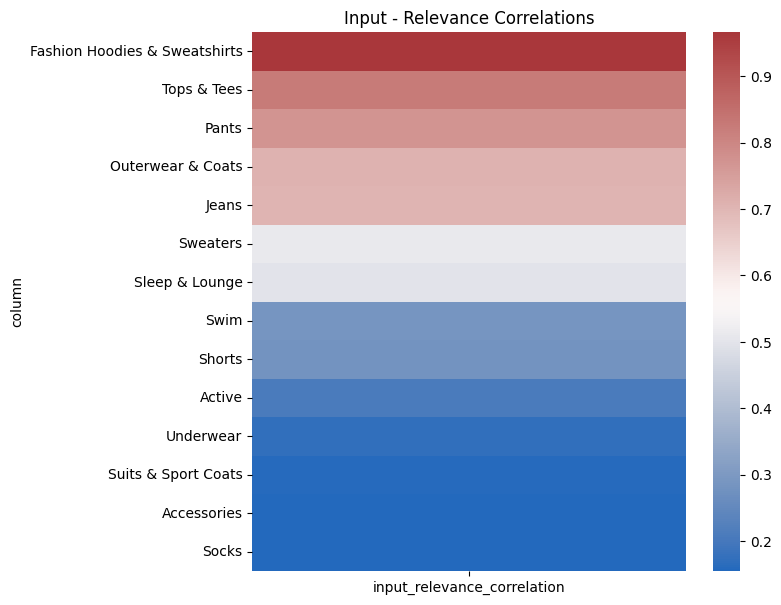

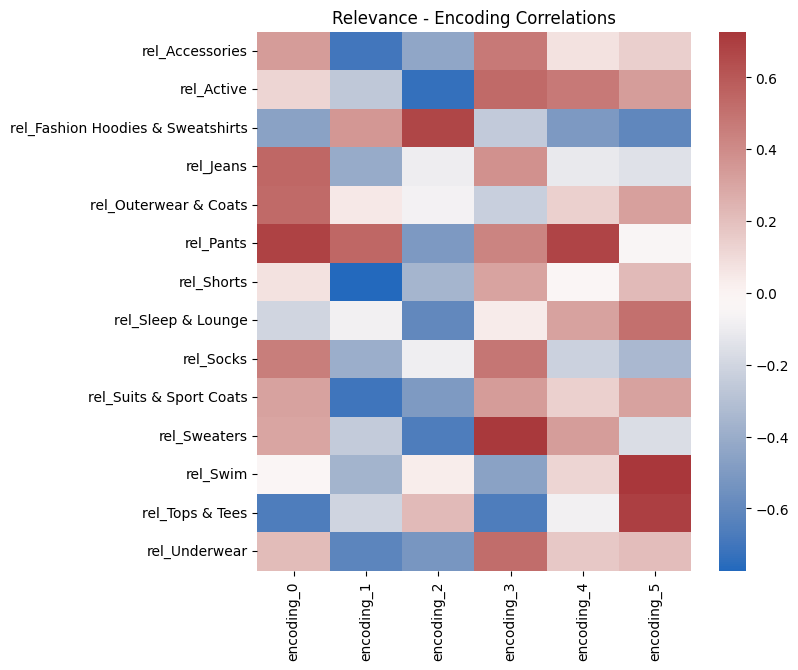

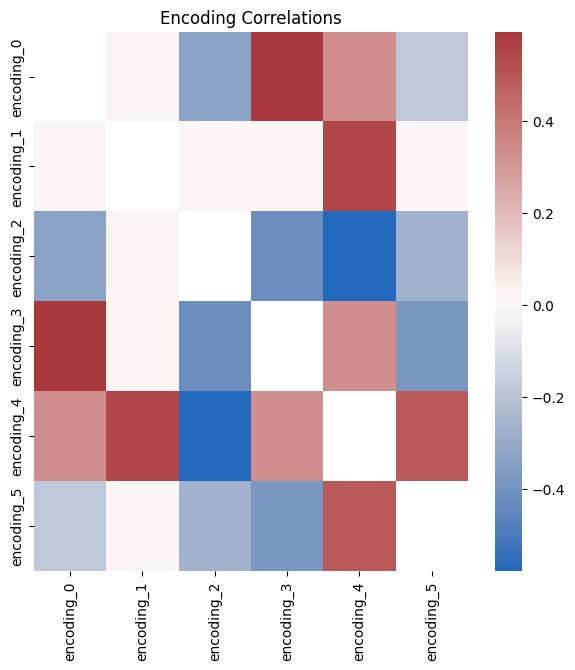

In [34]:
encoded, decoded = ae(X_pred_scaled)

lrp = LinearLRP(ae.encoder, top_k=1)
lrp_out = lrp(X_pred_scaled)

df_pred_scaled = pd.DataFrame(X_pred_scaled.numpy(), columns=X_test.columns)
df_explain, columns_map = make_explanation_df(df_pred_scaled, lrp_out, encoded)
corr_dfs = explanation_corrs(df_explain, columns_map)
plot_explanation_corrs(**corr_dfs)

# Clustering Customers by Encodings

In [35]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
            
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)

        if np.unique(y).shape[0] > 1:
            silhouette = silhouette_score(X, y)
        else:
            silhouette = -1
        
        if model_type == KMeans:
            error = model.inertia_ 
        else:
            error = None
            
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model,
            'silhouette_score': silhouette,
            'error': error
        }
        
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Error: {error}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [36]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [37]:
scaler_kmeans = MinMaxScaler()
X_scaled = scaler_kmeans.fit_transform(X_encoded)
X_scaled

array([[0.8010006 , 0.05808993, 0.5429466 , 0.73308736, 0.45208842,
        0.4804795 ],
       [0.4930998 , 0.19845414, 0.3649764 , 0.6344639 , 0.33340248,
        0.3103376 ],
       [0.75609756, 0.33330768, 0.27846986, 0.82531863, 0.6516493 ,
        0.47620994],
       ...,
       [0.03625667, 0.41847765, 0.7857065 , 0.01302707, 0.28429908,
        0.53059435],
       [0.75711524, 0.06945646, 0.40258068, 0.79293036, 0.43396437,
        0.46569365],
       [0.62011856, 0.1512531 , 0.38909468, 0.2764467 , 0.46149886,
        0.68354595]], dtype=float32)

In [38]:
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X_encoded)
X_pca

array([[-0.01766339,  1.7238097 ,  0.32350695,  0.5490775 ,  0.61112916],
       [-1.288334  , -0.04880643, -1.3955443 , -0.8416195 , -0.2576549 ],
       [ 1.7530533 , -0.01847005, -0.04547375, -0.50374913,  0.16572481],
       ...,
       [-3.4529426 , -4.4670124 , -1.7313218 ,  0.37951267,  0.10547894],
       [-0.1197404 ,  1.5552684 ,  0.27643222, -0.02762151,  0.29569888],
       [-0.6340045 , -0.4217534 ,  1.2674745 ,  0.6933423 , -0.3869133 ]],
      dtype=float32)

In [39]:
pca.explained_variance_ratio_

array([0.37551838, 0.3221735 , 0.21499752, 0.05996149, 0.01978137],
      dtype=float32)

In [40]:
X_pca.shape

(16344, 5)

In [41]:
hyperparams = [{'n_clusters': i} for i in range(2, 16)]
kmeans_results = search_clustering_hyperparams(KMeans, hyperparams, X_pca, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.3522665500640869 | Error: 90772.8515625
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.4407157599925995 | Error: 56338.859375
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.4956190288066864 | Error: 36517.5390625
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.4735657572746277 | Error: 32172.7421875
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.43712741136550903 | Error: 29061.421875
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.44672468304634094 | Error: 26608.81640625
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.3468622863292694 | Error: 23886.76953125
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.36903616786003113 | Error: 20827.466796875
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.3815551698207855 | Error: 18475.0546875
{'n_clusters': 11, 'random_state': 42} | Silhouette Score: 0.3895518481731415 | Error: 17646.8

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

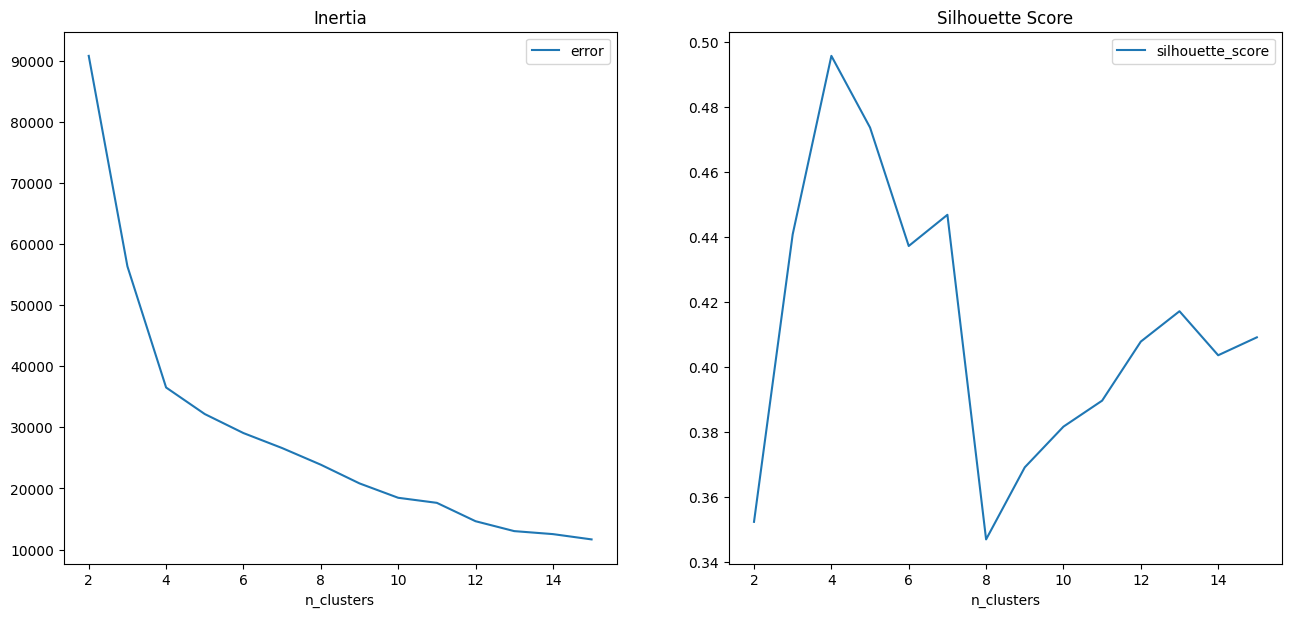

In [42]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)
 
axs[0].set_title('Inertia')
kmeans_results.plot(x='n_clusters', y='error', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [43]:
kmeans = kmeans_results.loc[kmeans_results.n_clusters==4, 'model'].iloc[0]
labels = kmeans.labels_

# Profiling Clusters

In [44]:
pd.Series(labels).value_counts()

0    8073
1    3144
2    3010
3    2117
Name: count, dtype: int64

In [45]:
Xy = pd.DataFrame(X_encoded)
Xy['segment'] = labels

Xy_cats = pd.DataFrame(X_cats)
Xy_cats['segment'] = labels

Xy_cats_bin = pd.DataFrame(X_cats > 0).astype(int)
Xy_cats_bin['segment'] = labels

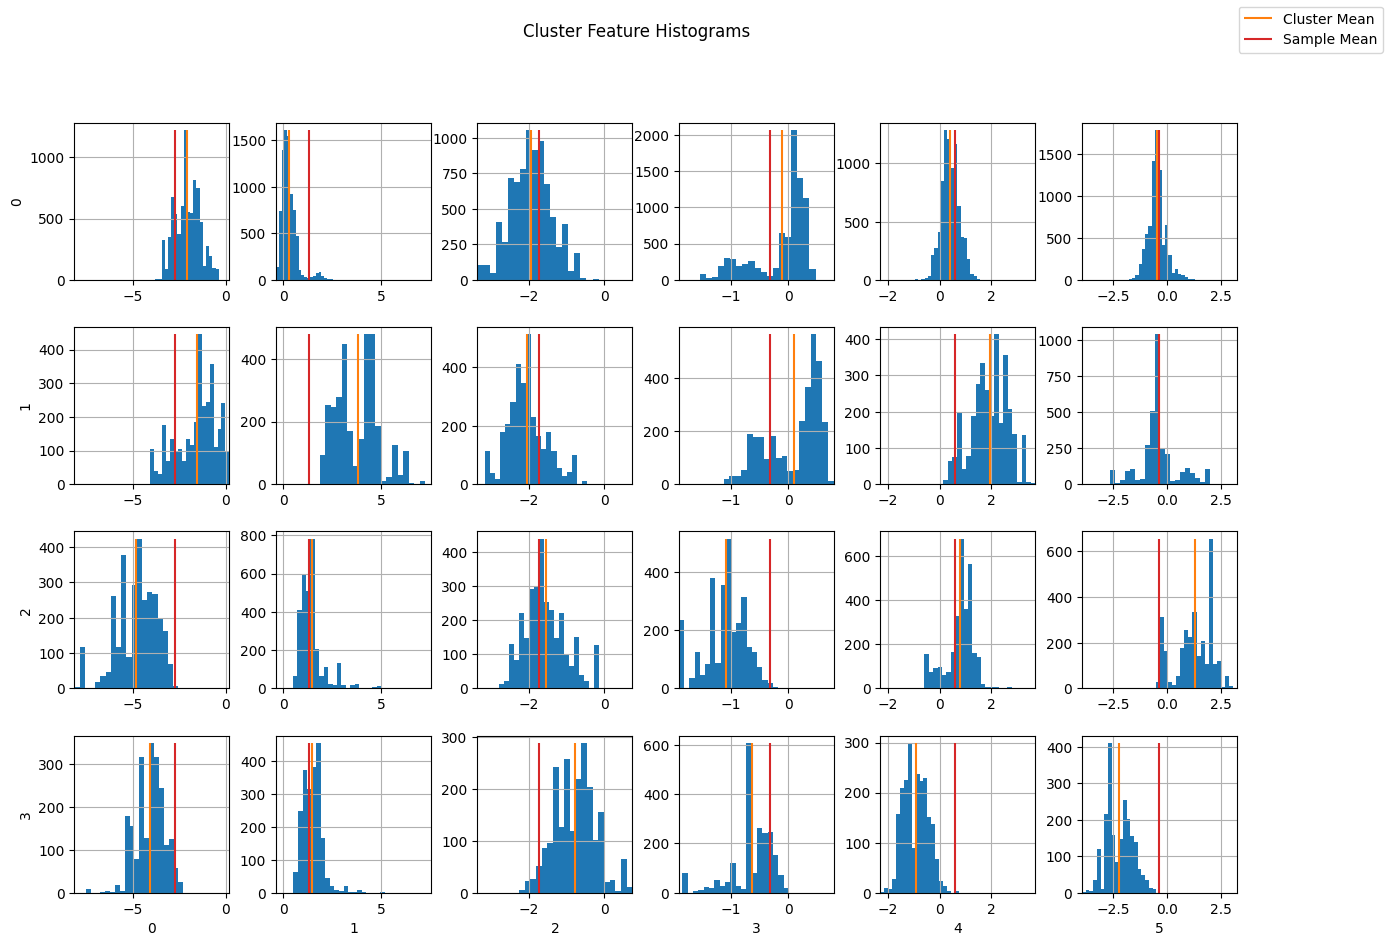

In [46]:
plot_clusters(Xy.drop(columns='segment'), Xy['segment'])

[Text(0.5, 1.0, 'Segment Means - Norm. by Overall Mean')]

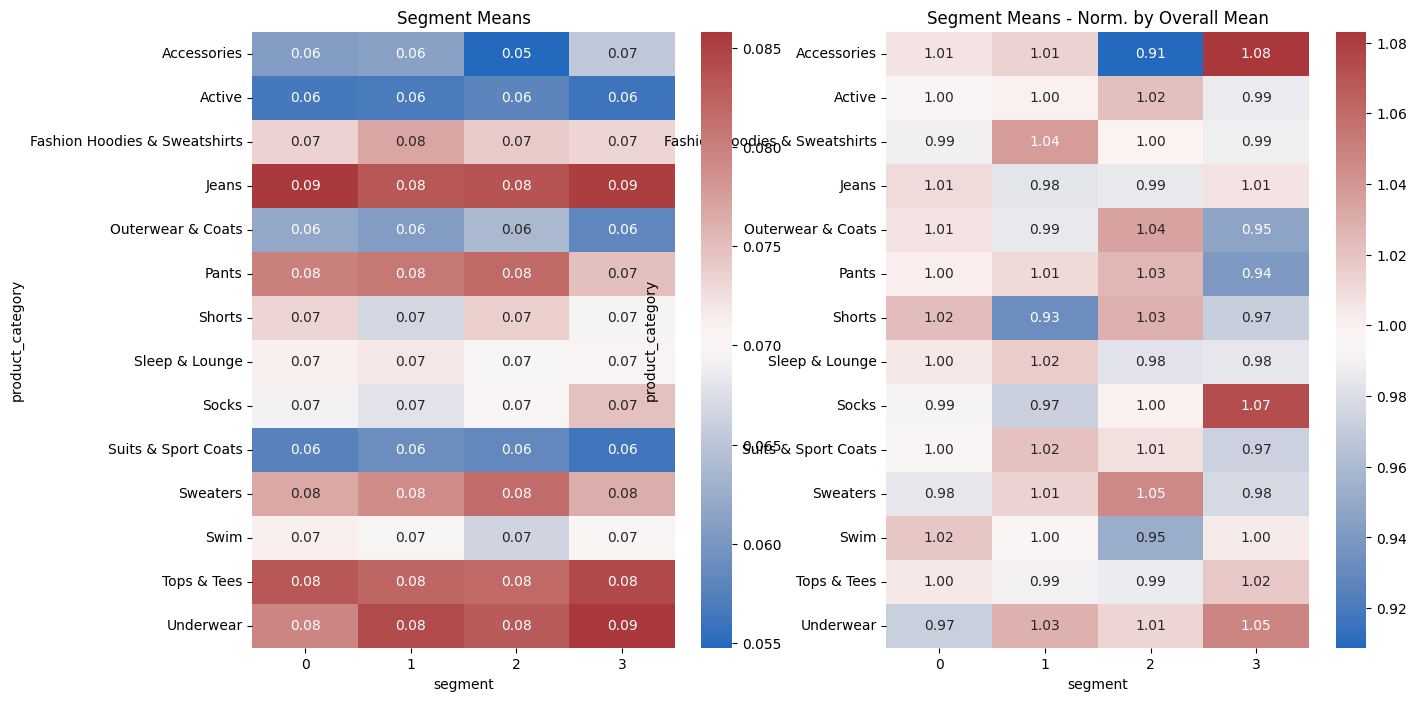

In [47]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.heatmap(Xy_cats.groupby('segment').mean().T, cmap='vlag', annot=True, fmt='.2f', ax=axs[0])
axs[0].set(title='Segment Means')

cluster_means_norm = Xy_cats.groupby('segment').mean() / Xy_cats.drop(columns='segment').mean()
sns.heatmap(
    cluster_means_norm.T, 
    cmap='vlag',
    annot=True, 
    fmt='.2f', 
    ax=axs[1]
)
axs[1].set(title='Segment Means - Norm. by Overall Mean')

[Text(0.5, 1.0, 'Percentage Customers Purchased - Norm. by Overall Percent.')]

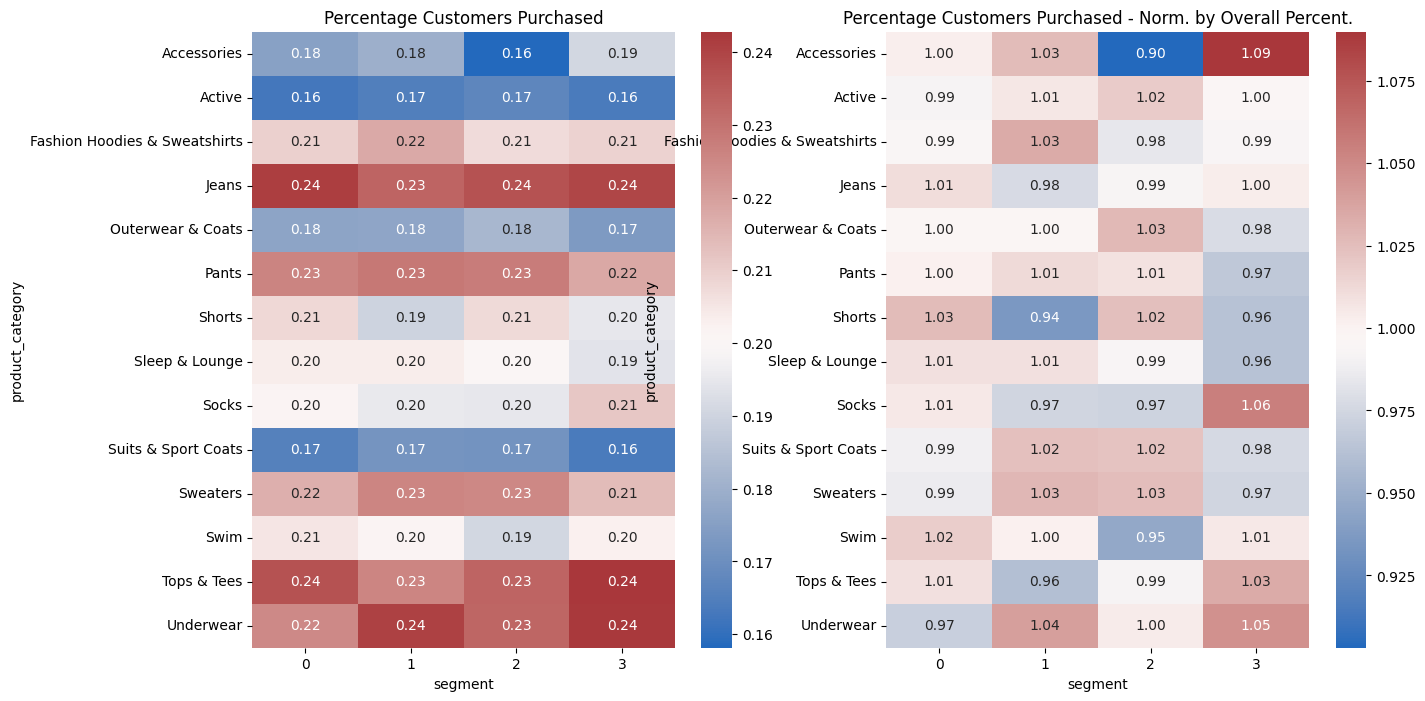

In [48]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.heatmap(Xy_cats_bin.groupby('segment').mean().T, cmap='vlag', annot=True, fmt='.2f', ax=axs[0])
axs[0].set(title='Percentage Customers Purchased')

cluster_means_norm = Xy_cats_bin.groupby('segment').mean() / Xy_cats_bin.drop(columns='segment').mean()
sns.heatmap(cluster_means_norm.T, cmap='vlag', annot=True, fmt='.2f', ax=axs[1])
axs[1].set(title='Percentage Customers Purchased - Norm. by Overall Percent.')

[Text(0.5, 1.0, 'Segment Relevance Means - Norm. by Overall Mean')]

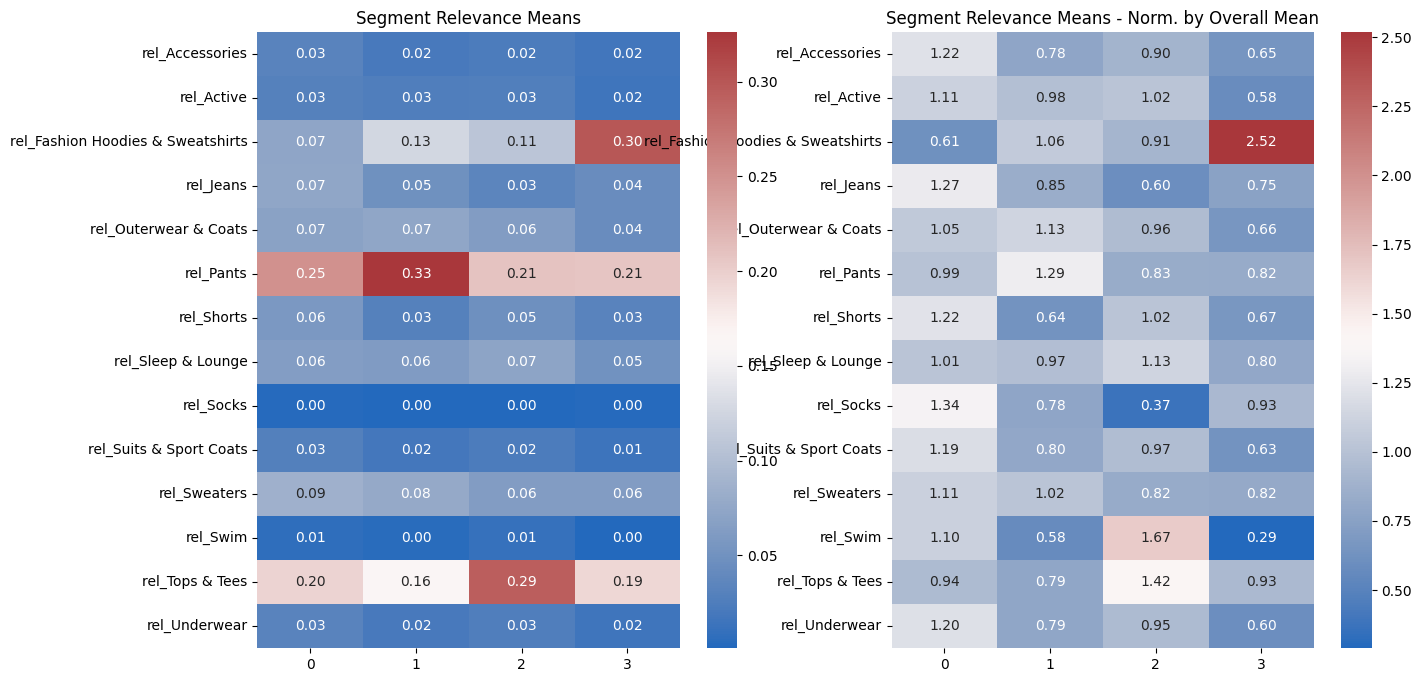

In [49]:
rel_cols = [col for col in df_explain.columns if col.startswith('rel_')]
X_rel = df_explain[rel_cols]

fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.heatmap(X_rel.groupby(labels).mean().T, cmap='vlag', annot=True, fmt='.2f', ax=axs[0])
axs[0].set(title='Segment Relevance Means')

cluster_means_norm = X_rel.groupby(labels).mean() / X_rel.mean()
sns.heatmap(
    cluster_means_norm.T, 
    cmap='vlag',
    annot=True, 
    fmt='.2f', 
    ax=axs[1]
)
axs[1].set(title='Segment Relevance Means - Norm. by Overall Mean')

In [51]:
centroids_encoded = pca.inverse_transform(kmeans.cluster_centers_)
centroids_encoded = scaler_kmeans.inverse_transform(centroids_encoded)
centroids_encoded = torch.tensor(centroids_encoded)
centroids_decoded = ae.decoder(centroids_encoded).detach().numpy()
centroids_decoded = scaler_autoencoder.inverse_transform(centroids_decoded)
centroids_decoded = pd.DataFrame(centroids_decoded, columns=X_cats.columns)

[Text(0.5, 1.0, 'Centroids Decoded - Norm. by Mean')]

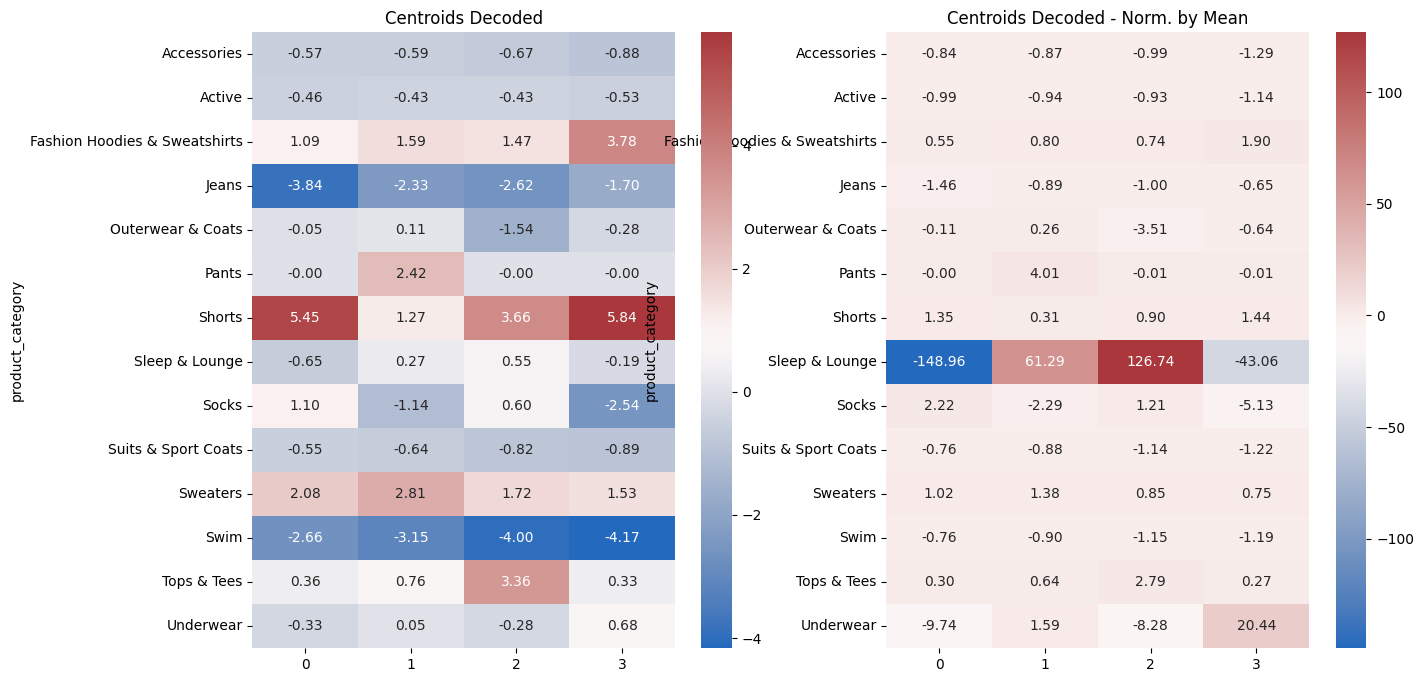

In [52]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.heatmap(centroids_decoded.T, cmap='vlag', annot=True, fmt='.2f', ax=axs[0])
axs[0].set(title='Centroids Decoded')

cluster_means_norm = centroids_decoded / centroids_decoded.mean().abs()
sns.heatmap(
    cluster_means_norm.T, 
    cmap='vlag',
    annot=True, 
    fmt='.2f',
    ax=axs[1]
)
axs[1].set(title='Centroids Decoded - Norm. by Mean')

In [53]:
category_segment_map = {
    0: 'Average: Jeans, Pants, Tops & Tees, Underwear',
    1: 'Jeans, Outerwear & Coats',
    2: 'Jeans, Tops & Tees',
    3: 'Pants, Sweaters, Shorts',
}

# Saving Pipelines

In [54]:
category_segment_pipe = Pipeline([('scaler', scaler_kmeans), ('pca', pca), ('kmeans', kmeans)])

In [55]:
with open('../models/category_segment_pipe.pkl', 'wb') as f:
    pkl.dump(category_segment_pipe, f)

In [56]:
with open('../models/category_segment_pipe.pkl', 'rb') as f:
    category_segment_pipe_loaded = pkl.load(f)

In [57]:
labels = category_segment_pipe_loaded.predict(X_encoded)
(labels == kmeans.labels_).all()

np.False_

In [58]:
labels.sum()

np.int64(0)

In [959]:
X = scaler_kmeans.transform(X_encoded)
X = pca.transform(X)
labels = kmeans.predict(X)

In [960]:
category_segment_pipe_loaded.predict(X_encoded)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [962]:
category_segment_pipe_loaded.steps[2][1].cluster_centers_

array([[-1.618793  ,  0.22214341, -0.09216647, -0.01796247,  0.01770773],
       [ 3.3003387 ,  1.8646288 , -0.71067524,  0.03198028, -0.01357814],
       [ 1.0225849 ,  0.07115218,  1.6233933 ,  0.05150208, -0.08404066],
       [ 1.4465495 , -2.3158262 , -0.47089797, -0.01354649,  0.02606057]],
      dtype=float32)

In [927]:
with open('../models/category_segment_map.json', 'w') as f:
    json.dump(category_segment_map, f)

In [928]:
with open('../models/category_segment_map.json', 'r') as f:
    category_segment_map_loaded = json.load(f)

In [929]:
category_segment_map

{0: 'Average: Jeans, Pants, Tops & Tees, Underwear',
 1: 'Jeans, Outerwear & Coats',
 2: 'Jeans, Tops & Tees',
 3: 'Pants, Sweaters, Shorts'}